# Notebook 1: Pandas Limitations & Optimization

## BigData E-commerce Analytics Project

**Objective**: Demonstrate that Pandas does NOT scale beyond 10-20M records

**Dataset**: 
- Source: `data/sample/`
- Transactions: 20M records (~2-3 GB)
- Customers: 20K records
- Products: 1K records

**Learning Outcomes**:
1. Understand Pandas memory model and limitations
2. Learn memory profiling techniques
3. Apply dtype optimization strategies
4. Implement chunking for large datasets
5. Recognize when to move to distributed computing

---

## Part 0: Setup & Environment

Import libraries and define helper functions for memory profiling and performance measurement.

In [1]:
# SETUP

# Standard library imports
import pandas as pd
import numpy as np
import time
import os
import gc
from pathlib import Path

# Memory profiling
import psutil

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Pandas configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: f'{x:.2f}')

print("Libraries imported successfully!")

# Helper Functions

def get_memory_usage():
    """Get current process memory usage in MB"""
    process = psutil.Process()
    return process.memory_info().rss / 1024 / 1024

def measure_performance(func, *args, **kwargs):
    """Measure execution time and memory usage of a function"""
    gc.collect()  # Force garbage collection
    
    mem_before = get_memory_usage()
    start_time = time.time()
    
    result = func(*args, **kwargs)
    
    elapsed_time = time.time() - start_time
    mem_after = get_memory_usage()
    mem_used = mem_after - mem_before
    
    return result, elapsed_time, mem_used

def format_bytes(bytes_value):
    """Format bytes to human-readable string"""
    for unit in ['B', 'KB', 'MB', 'GB']:
        if bytes_value < 1024.0:
            return f"{bytes_value:.2f} {unit}"
        bytes_value /= 1024.0
    return f"{bytes_value:.2f} TB"

print("Helper functions defined!")

# Data paths
DATA_DIR = Path("../data/sample/")
RESULTS_DIR = Path("../results")
GRAPH_DIR = Path("../docs/graphs")   

# File paths
TRANSACTIONS_FILE = DATA_DIR / "transactions.csv"
CUSTOMERS_FILE = DATA_DIR / "customers.csv"
PRODUCTS_FILE = DATA_DIR / "products.csv"

# Verify files exist
print("Checking data files...")
for file_path in [TRANSACTIONS_FILE, CUSTOMERS_FILE, PRODUCTS_FILE]:
    if file_path.exists():
        size = file_path.stat().st_size
        print(f"  {file_path.name}: {format_bytes(size)}")
    else:
        print(f"  {file_path.name}: NOT FOUND")
        
print(f"\nResults will be saved to: {RESULTS_DIR}")

Libraries imported successfully!
Helper functions defined!
Checking data files...
  transactions.csv: 2.27 GB
  customers.csv: 3.10 MB
  products.csv: 88.19 KB

Results will be saved to: ../results


---

## Part 1: Naive Loading - The Problem

**Objective**: Demonstrate that loading 20M records naively causes significant memory issues

We'll observe:
- Memory expansion (CSV size vs DataFrame memory)
- Loading time
- Memory breakdown by column

PART 1: NAIVE LOADING - THE PROBLEM

Baseline memory usage: 199.22 MB

Loading 20M transactions with Pandas (naive approach)...
This may take 30-60 seconds...

  Loaded 20,000,000 records in 34.51 seconds

Memory Usage:
  Before loading: 199.22 MB
  After loading:  5446.20 MB
  Memory used:    5246.97 MB (5.12 GB)

File vs Memory:
  CSV file size:     2323.09 MB
  DataFrame memory:  5246.97 MB
  Expansion factor:  2.26x

DATAFRAME INFO

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000000 entries, 0 to 19999999
Data columns (total 14 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   transaction_id         object 
 1   customer_id            object 
 2   product_id             object 
 3   quantity               int64  
 4   unit_price             float64
 5   total_amount           float64
 6   discount_pct           float64
 7   discount_amount        float64
 8   final_amount           float64
 9   shipping_cost          float64
 10  transac

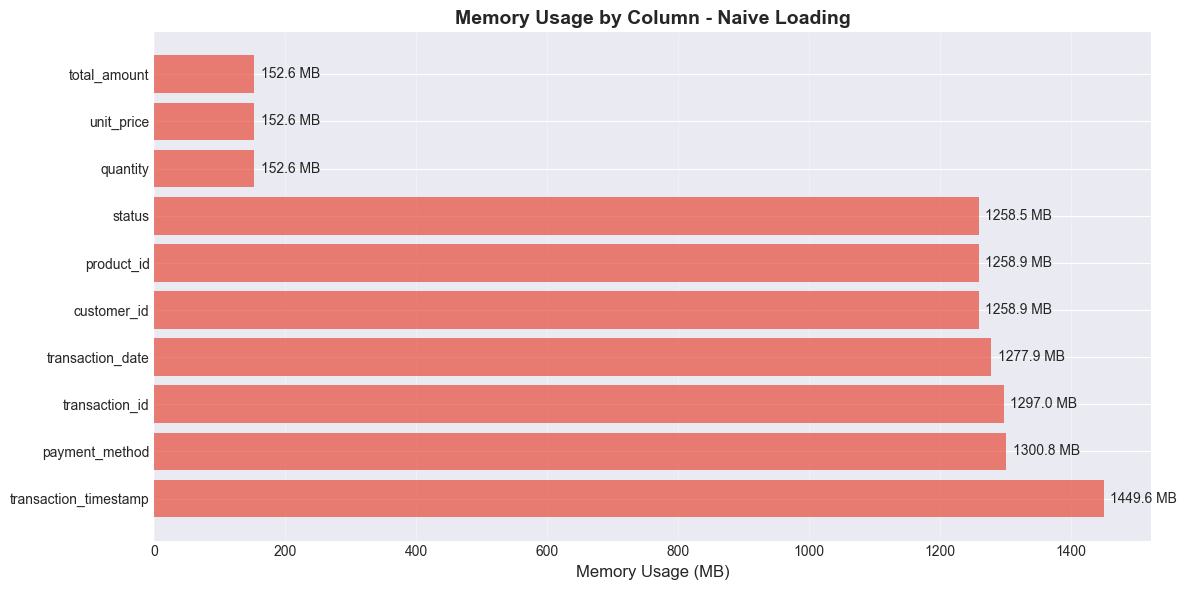


Saved: 01_naive_memory_breakdown.png


In [2]:
# NAIVE LOADING

print("="*70)
print("PART 1: NAIVE LOADING - THE PROBLEM")
print("="*70)

# Baseline memory
baseline_memory = get_memory_usage()
print(f"\nBaseline memory usage: {baseline_memory:.2f} MB\n")

# Load transactions naively
print("Loading 20M transactions with Pandas (naive approach)...")
print("This may take 30-60 seconds...\n")

start_time = time.time()
mem_before = get_memory_usage()

df = pd.read_csv(TRANSACTIONS_FILE)

load_time = time.time() - start_time
mem_after = get_memory_usage()
mem_used = mem_after - mem_before

print(f"  Loaded {len(df):,} records in {load_time:.2f} seconds")
print(f"\nMemory Usage:")
print(f"  Before loading: {mem_before:.2f} MB")
print(f"  After loading:  {mem_after:.2f} MB")
print(f"  Memory used:    {mem_used:.2f} MB ({mem_used/1024:.2f} GB)")

# File size vs memory comparison
file_size_mb = TRANSACTIONS_FILE.stat().st_size / 1024 / 1024
expansion_factor = mem_used / file_size_mb
print(f"\nFile vs Memory:")
print(f"  CSV file size:     {file_size_mb:.2f} MB")
print(f"  DataFrame memory:  {mem_used:.2f} MB")
print(f"  Expansion factor:  {expansion_factor:.2f}x")
# DataFrame info
print("\n" + "="*70)
print("DATAFRAME INFO")
print("="*70 + "\n")

df.info(memory_usage='deep')

# Memory breakdown by column
print("\n" + "="*70)
print("MEMORY USAGE BY COLUMN")
print("="*70 + "\n")

memory_by_column = df.memory_usage(deep=True) / 1024**2  # Convert to MB
memory_sorted = memory_by_column.sort_values(ascending=False)

print("Top 10 columns by memory usage:\n")
for col, mem in memory_sorted.head(10).items():
    if col == 'Index':
        continue
    dtype = df[col].dtype
    print(f"  {col:<25} {mem:>10.2f} MB  ({dtype})")

print(f"\n  {'TOTAL':<25} {memory_sorted.sum():>10.2f} MB")
# Visualization: Memory breakdown
plt.figure(figsize=(12, 6))

top_cols = memory_by_column[memory_by_column.index != 'Index'].nlargest(10)

plt.barh(range(len(top_cols)), top_cols.values, color='#e74c3c', alpha=0.7)
plt.yticks(range(len(top_cols)), top_cols.index)
plt.xlabel('Memory Usage (MB)', fontsize=12)
plt.title('Memory Usage by Column - Naive Loading', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

for i, v in enumerate(top_cols.values):
    plt.text(v + 10, i, f'{v:.1f} MB', va='center')

plt.tight_layout()
plt.savefig(GRAPH_DIR / '01_naive_memory_breakdown.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nSaved: 01_naive_memory_breakdown.png")

### Key Observations

From the naive loading approach:

1. **Memory Expansion**: DataFrame uses 2-3x more memory than CSV file
2. **Inefficient Data Types**: Default dtypes (int64, float64, object) are memory-intensive
3. **String Columns**: Object type columns use excessive memory
4. **Loading Time**: 30-60 seconds for 20M records

**Conclusion**: Pandas' default behavior is NOT optimized for large datasets!

---

## Part 2: Basic Operations - Performance Baseline

**Objective**: Measure performance of common operations

We'll test:
- Filtering
- GroupBy aggregations
- Date parsing
- Complex multi-level aggregations

PART 2: BASIC OPERATIONS - PERFORMANCE BASELINE

[1/4] Filter Operation...
  Task: Filter transactions with final_amount > 100
    Time: 1.33s, Memory: 1535.68 MB

[2/4] GroupBy Aggregation...
  Task: Aggregate by payment_method
    Time: 1.22s, Memory: -43.62 MB

  Result:
                           sum   mean    count
payment_method                                
bank_transfer    1599736228.38 400.18  3997512
cash_on_delivery 1602877319.02 400.93  3997892
credit_card      1603453318.20 400.84  4000189
debit_card       1604641439.11 401.00  4001603
paypal           1602866396.04 400.44  4002804

[3/4] Date Parsing...
    Time: 2.00s, Memory: 152.93 MB

[4/4] Complex Aggregation...
    Time: 6.89s, Memory: 153.47 MB

  Result preview:
                                 sum   count
month   payment_method                      
2022-01 bank_transfer    44802942.13  111609
        cash_on_delivery 44642259.55  111172
        credit_card      44292420.15  111020
        debit_card       4498

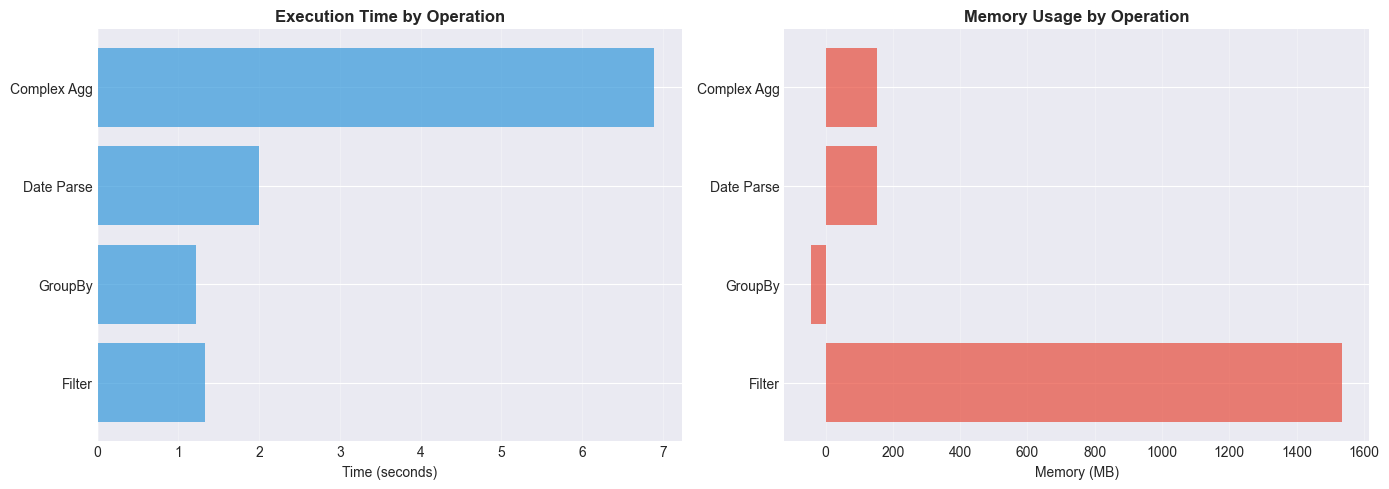

Saved: 01_baseline_performance.png


In [3]:
# BASIC OPERATIONS

print("="*70)
print("PART 2: BASIC OPERATIONS - PERFORMANCE BASELINE")
print("="*70 + "\n")

performance_results = {}
# Operation 1: Filter
print("[1/4] Filter Operation...")
print("  Task: Filter transactions with final_amount > 100")

_, time_filter, mem_filter = measure_performance(
    lambda: df[df['final_amount'] > 100]
)

performance_results['Filter'] = {'time': time_filter, 'memory': mem_filter}
print(f"    Time: {time_filter:.2f}s, Memory: {mem_filter:.2f} MB\n")
# Operation 2: GroupBy
print("[2/4] GroupBy Aggregation...")
print("  Task: Aggregate by payment_method")

def groupby_op():
    return df.groupby('payment_method')['final_amount'].agg(['sum', 'mean', 'count'])

result_gb, time_gb, mem_gb = measure_performance(groupby_op)
performance_results['GroupBy'] = {'time': time_gb, 'memory': mem_gb}

print(f"    Time: {time_gb:.2f}s, Memory: {mem_gb:.2f} MB")
print("\n  Result:")
print(result_gb)
print()
# Operation 3: Date parsing
print("[3/4] Date Parsing...")
_, time_date, mem_date = measure_performance(
    lambda: pd.to_datetime(df['transaction_date'])
)
performance_results['Date Parse'] = {'time': time_date, 'memory': mem_date}
print(f"    Time: {time_date:.2f}s, Memory: {mem_date:.2f} MB\n")
# Operation 4: Complex aggregation
print("[4/4] Complex Aggregation...")

def complex_agg():
    df_temp = df.copy()
    df_temp['month'] = pd.to_datetime(df_temp['transaction_date']).dt.to_period('M')
    return df_temp.groupby(['month', 'payment_method'])['final_amount'].agg(['sum', 'count'])

result_cx, time_cx, mem_cx = measure_performance(complex_agg)
performance_results['Complex Agg'] = {'time': time_cx, 'memory': mem_cx}

print(f"    Time: {time_cx:.2f}s, Memory: {mem_cx:.2f} MB")
print("\n  Result preview:")
print(result_cx.head(10))

# Performance summary
print("\n" + "="*70)
print("PERFORMANCE SUMMARY")
print("="*70 + "\n")

perf_df = pd.DataFrame(performance_results).T
perf_df.columns = ['Time (s)', 'Memory (MB)']
print(perf_df.round(2))
print(f"\nTotal time: {perf_df['Time (s)'].sum():.2f}s")

perf_df.to_csv(RESULTS_DIR / '01_baseline_performance.csv')
print("\nSaved: 01_baseline_performance.csv")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.barh(perf_df.index, perf_df['Time (s)'], color='#3498db', alpha=0.7)
ax1.set_xlabel('Time (seconds)')
ax1.set_title('Execution Time by Operation', fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

ax2.barh(perf_df.index, perf_df['Memory (MB)'], color='#e74c3c', alpha=0.7)
ax2.set_xlabel('Memory (MB)')
ax2.set_title('Memory Usage by Operation', fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(GRAPH_DIR / '01_baseline_performance.png', dpi=300)
plt.show()

print("Saved: 01_baseline_performance.png")

## Part 3: Dtype Optimization

**Objective**: Reduce memory by optimizing data types

Strategies:
- Convert repeated strings to `category`
- Downcast int64 to int32 where possible
- Downcast float64 to float32

PART 3: DTYPE OPTIMIZATION

Original memory: 10169.57 MB

Optimizing categorical columns...

payment_method:
  Unique values: 5
  Before: 1300.78 MB (object)
  After:  19.07 MB (category)
  Reduction: 98.5%

status:
  Unique values: 3
  Before: 1258.47 MB (object)
  After:  19.07 MB (category)
  Reduction: 98.5%

Optimizing integer columns...

quantity:
  Range: [1, 5]
  Before: 152.59 MB (int64)
  After:  76.29 MB (int32)
  Reduction: 50.0%

Optimizing float columns...

unit_price:
  Before: 152.59 MB (float64)
  After:  76.29 MB (float32)
  Reduction: 50.0%

total_amount:
  Before: 152.59 MB (float64)
  After:  76.29 MB (float32)
  Reduction: 50.0%

discount_pct:
  Before: 152.59 MB (float64)
  After:  76.29 MB (float32)
  Reduction: 50.0%

final_amount:
  Before: 152.59 MB (float64)
  After:  76.29 MB (float32)
  Reduction: 50.0%

shipping_cost:
  Before: 152.59 MB (float64)
  After:  76.29 MB (float32)
  Reduction: 50.0%

MEMORY OPTIMIZATION SUMMARY

Original:  10169.57 MB
Optimize

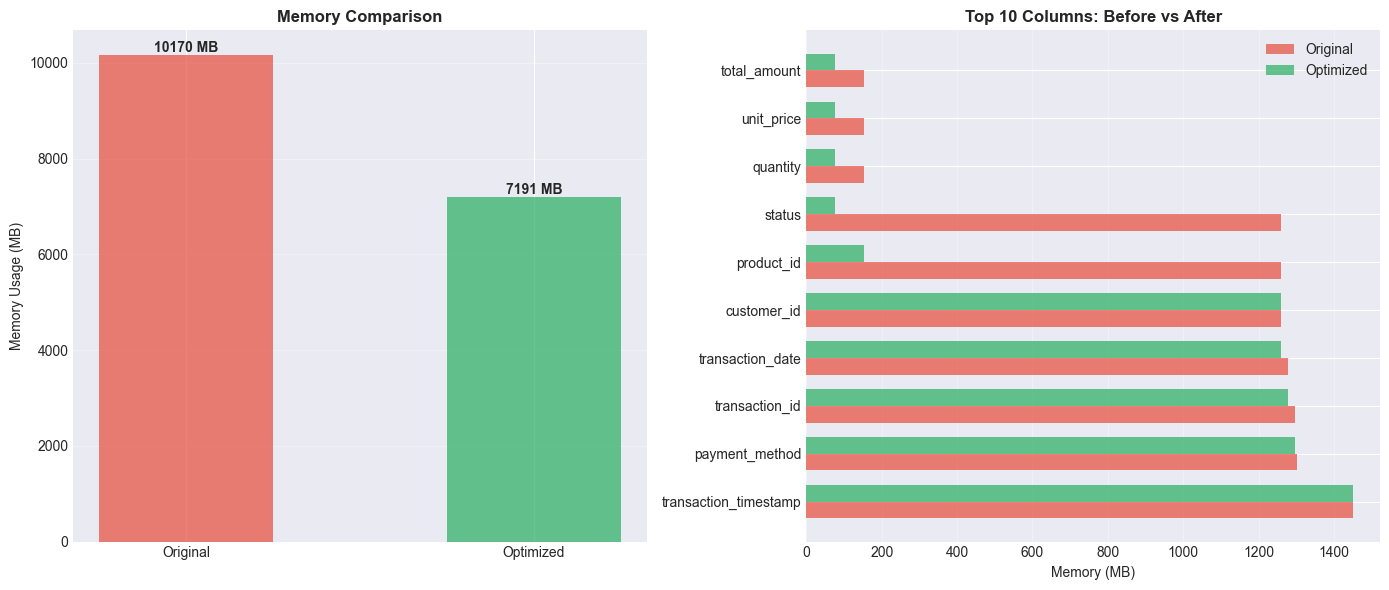


Saved: 01_dtype_optimization.png


In [4]:
# DTYPE OPTIMIZATION

print("="*70)
print("PART 3: DTYPE OPTIMIZATION")
print("="*70 + "\n")

# Original memory
original_memory = df.memory_usage(deep=True).sum() / 1024**2
print(f"Original memory: {original_memory:.2f} MB\n")

# Create optimized copy
df_optimized = df.copy()

# Optimize categorical columns
print("Optimizing categorical columns...\n")

categorical_cols = ['payment_method', 'status']
for col in categorical_cols:
    mem_before = df[col].memory_usage(deep=True) / 1024**2
    
    df_optimized[col] = df_optimized[col].astype('category')
    
    mem_after = df_optimized[col].memory_usage(deep=True) / 1024**2
    reduction = ((mem_before - mem_after) / mem_before) * 100
    
    print(f"{col}:")
    print(f"  Unique values: {df[col].nunique()}")
    print(f"  Before: {mem_before:.2f} MB ({df[col].dtype})")
    print(f"  After:  {mem_after:.2f} MB (category)")
    print(f"  Reduction: {reduction:.1f}%\n")

# Optimize integer columns
print("Optimizing integer columns...\n")

# Check if int64 can be downcast to int32
int_cols = ['quantity']
for col in int_cols:
    if col in df.columns:
        col_min, col_max = df[col].min(), df[col].max()
        
        # Check if fits in int32
        if col_min >= np.iinfo(np.int32).min and col_max <= np.iinfo(np.int32).max:
            mem_before = df[col].memory_usage() / 1024**2
            
            df_optimized[col] = df_optimized[col].astype('int32')
            
            mem_after = df_optimized[col].memory_usage() / 1024**2
            reduction = ((mem_before - mem_after) / mem_before) * 100
            
            print(f"{col}:")
            print(f"  Range: [{col_min}, {col_max}]")
            print(f"  Before: {mem_before:.2f} MB (int64)")
            print(f"  After:  {mem_after:.2f} MB (int32)")
            print(f"  Reduction: {reduction:.1f}%\n")

# Optimize float columns
print("Optimizing float columns...\n")

float_cols = ['unit_price', 'total_amount', 'discount_pct', 'final_amount', 'shipping_cost']
for col in float_cols:
    if col in df.columns:
        mem_before = df[col].memory_usage() / 1024**2
        
        df_optimized[col] = df_optimized[col].astype('float32')
        
        mem_after = df_optimized[col].memory_usage() / 1024**2
        reduction = ((mem_before - mem_after) / mem_before) * 100
        
        print(f"{col}:")
        print(f"  Before: {mem_before:.2f} MB (float64)")
        print(f"  After:  {mem_after:.2f} MB (float32)")
        print(f"  Reduction: {reduction:.1f}%\n")

# Memory comparison summary
optimized_memory = df_optimized.memory_usage(deep=True).sum() / 1024**2
memory_saved = original_memory - optimized_memory
reduction_pct = (memory_saved / original_memory) * 100

print("="*70)
print("MEMORY OPTIMIZATION SUMMARY")
print("="*70 + "\n")
print(f"Original:  {original_memory:.2f} MB")
print(f"Optimized: {optimized_memory:.2f} MB")
print(f"Saved:     {memory_saved:.2f} MB ({reduction_pct:.1f}% reduction)")

# Visualization: Memory comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart comparison
ax1 = axes[0]
categories = ['Original', 'Optimized']
memory_values = [original_memory, optimized_memory]
colors = ['#e74c3c', '#27ae60']

bars = ax1.bar(categories, memory_values, color=colors, alpha=0.7, width=0.5)
ax1.set_ylabel('Memory Usage (MB)')
ax1.set_title('Memory Comparison', fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

for bar, value in zip(bars, memory_values):
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width()/2., height,
        f'{value:.0f} MB',
        ha='center', va='bottom', fontweight='bold')

# Column-wise comparison (top 10)
ax2 = axes[1]
original_cols = df.memory_usage(deep=True)[1:].nlargest(10) / 1024**2
optimized_cols = df_optimized.memory_usage(deep=True)[1:].nlargest(10) / 1024**2

x = np.arange(len(original_cols))
width = 0.35

ax2.barh(x - width/2, original_cols.values, width, label='Original', color='#e74c3c', alpha=0.7)
ax2.barh(x + width/2, optimized_cols.values, width, label='Optimized', color='#27ae60', alpha=0.7)

ax2.set_yticks(x)
ax2.set_yticklabels(original_cols.index)
ax2.set_xlabel('Memory (MB)')
ax2.set_title('Top 10 Columns: Before vs After', fontweight='bold')
ax2.legend()
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(GRAPH_DIR / '01_dtype_optimization.png', dpi=300)
plt.show()

print("\nSaved: 01_dtype_optimization.png")

# Clean up
del df, df_optimized
gc.collect()
time.sleep(10)

## Part 4: Chunking Strategy

**Objective**: Process large files in chunks to avoid memory errors

Benefits:
- Process data that doesn't fit in memory
- Control memory usage
- Enable streaming operations

PART 4: CHUNKING STRATEGY

Processing 20M records in chunks of 1,000,000...
Example 1: Chunked Aggregation

Chunk 1: 1,000,000 records in 0.08s
Chunk 2: 1,000,000 records in 0.08s
Chunk 3: 1,000,000 records in 0.08s
Chunk 4: 1,000,000 records in 0.08s
Chunk 5: 1,000,000 records in 0.08s
Chunk 6: 1,000,000 records in 0.08s
Chunk 7: 1,000,000 records in 0.09s
Chunk 8: 1,000,000 records in 0.08s
Chunk 9: 1,000,000 records in 0.08s
Chunk 10: 1,000,000 records in 0.09s
Chunk 11: 1,000,000 records in 0.08s
Chunk 12: 1,000,000 records in 0.08s
Chunk 13: 1,000,000 records in 0.09s
Chunk 14: 1,000,000 records in 0.09s
Chunk 15: 1,000,000 records in 0.08s
Chunk 16: 1,000,000 records in 0.08s
Chunk 17: 1,000,000 records in 0.08s
Chunk 18: 1,000,000 records in 0.08s
Chunk 19: 1,000,000 records in 0.08s
Chunk 20: 1,000,000 records in 0.08s

Processed 20 chunks

Combining chunk results...

Final aggregation by payment method:
                           sum    count   mean
payment_method             

/tmp/ipykernel_149555/1314857178.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  final_result = pd.concat(chunk_results).groupby(level=0).agg({


Processed 5,000,000 records, found 1,318,699 matching
Processed 10,000,000 records, found 2,636,691 matching
Processed 15,000,000 records, found 3,953,354 matching
Processed 20,000,000 records, found 5,271,126 matching

Final result:
  Total records processed: 20,000,000
  Matching records: 5,271,126
  Percentage: 26.36%


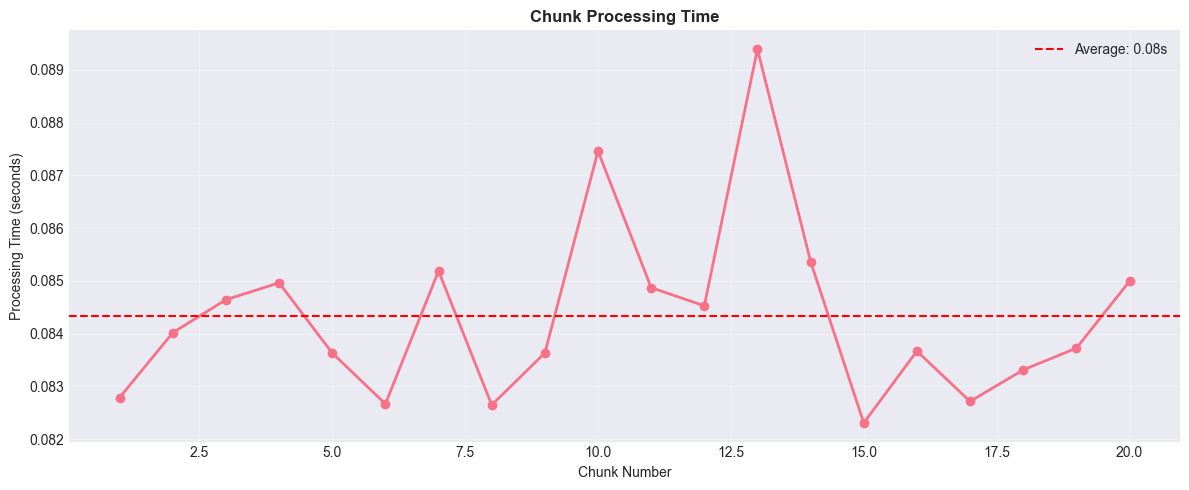


Saved: 01_chunk_performance.png


In [5]:
# CHUNKING STRATEGY

print("="*70)
print("PART 4: CHUNKING STRATEGY")
print("="*70 + "\n")

CHUNK_SIZE = 1_000_000  # 1M records per chunk

print(f"Processing 20M records in chunks of {CHUNK_SIZE:,}...")

# Example 1: Aggregate by payment method using chunks
print("Example 1: Chunked Aggregation\n")

chunk_results = []
chunk_times = []
chunk_count = 0

for chunk in pd.read_csv(TRANSACTIONS_FILE, chunksize=CHUNK_SIZE):
    chunk_count += 1
    start = time.time()
    
    # Optimize dtypes on chunk
    chunk['payment_method'] = chunk['payment_method'].astype('category')
    chunk['status'] = chunk['status'].astype('category')
    
    # Aggregate
    result = chunk.groupby('payment_method', observed=True)['final_amount'].agg(['sum', 'count'])
    chunk_results.append(result)
    
    elapsed = time.time() - start
    chunk_times.append(elapsed)
    
    print(f"Chunk {chunk_count}: {len(chunk):,} records in {elapsed:.2f}s")

print(f"\nProcessed {chunk_count} chunks")

# Combine chunk results
print("\nCombining chunk results...")
final_result = pd.concat(chunk_results).groupby(level=0).agg({
    'sum': 'sum',
    'count': 'sum'
})
final_result['mean'] = final_result['sum'] / final_result['count']

print("\nFinal aggregation by payment method:")
print(final_result)

# Example 2: Filtered loading with chunks
print("\n" + "="*70)
print("Example 2: Filtered Chunked Loading")
print("="*70 + "\n")

print("Loading only high-value transactions (final_amount > 500)...\n")

filtered_chunks = []
total_filtered = 0

for i, chunk in enumerate(pd.read_csv(TRANSACTIONS_FILE, chunksize=CHUNK_SIZE), 1):
    # Apply filter
    filtered = chunk[chunk['final_amount'] > 500]
    filtered_chunks.append(filtered)
    total_filtered += len(filtered)
    
    if i % 5 == 0:
        print(f"Processed {i * CHUNK_SIZE:,} records, found {total_filtered:,} matching")

# Combine
filtered_df = pd.concat(filtered_chunks, ignore_index=True)

print(f"\nFinal result:")
print(f"  Total records processed: {20_000_000:,}")
print(f"  Matching records: {len(filtered_df):,}")
print(f"  Percentage: {(len(filtered_df) / 20_000_000) * 100:.2f}%")

# Visualization: Chunk processing time
plt.figure(figsize=(12, 5))

plt.plot(range(1, len(chunk_times) + 1), chunk_times, marker='o', linewidth=2, markersize=6)
plt.axhline(np.mean(chunk_times), color='r', linestyle='--', label=f'Average: {np.mean(chunk_times):.2f}s')
plt.xlabel('Chunk Number')
plt.ylabel('Processing Time (seconds)')
plt.title('Chunk Processing Time', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(GRAPH_DIR / '01_chunk_performance.png', dpi=300)
plt.show()

print("\nSaved: 01_chunk_performance.png")

### Key Takeaways

**Chunking Advantages**:
- Process arbitrarily large files
- Control memory usage
- Enable streaming workflows

**Trade-offs**:
- Slightly slower than in-memory operations
- Requires aggregation logic
- Not suitable for operations requiring full dataset (e.g., sorting)

## Part 5: Selective Column Loading

**Objective**: Load only necessary columns to save memory

Use `usecols` parameter to load specific columns only.

PART 5: SELECTIVE COLUMN LOADING

Loading only 5 columns instead of all...

Comparison: Full vs Selective Loading

Full dataset:
  Columns: 14
  Load time: 38.73s
  Memory: 4157.62 MB

Selective loading:
  Columns: 5
  Load time: 18.34s
  Memory: 1828.32 MB

Savings:
  Time: 20.39s (52.6% faster)
  Memory: 2329.30 MB (56.0% less)


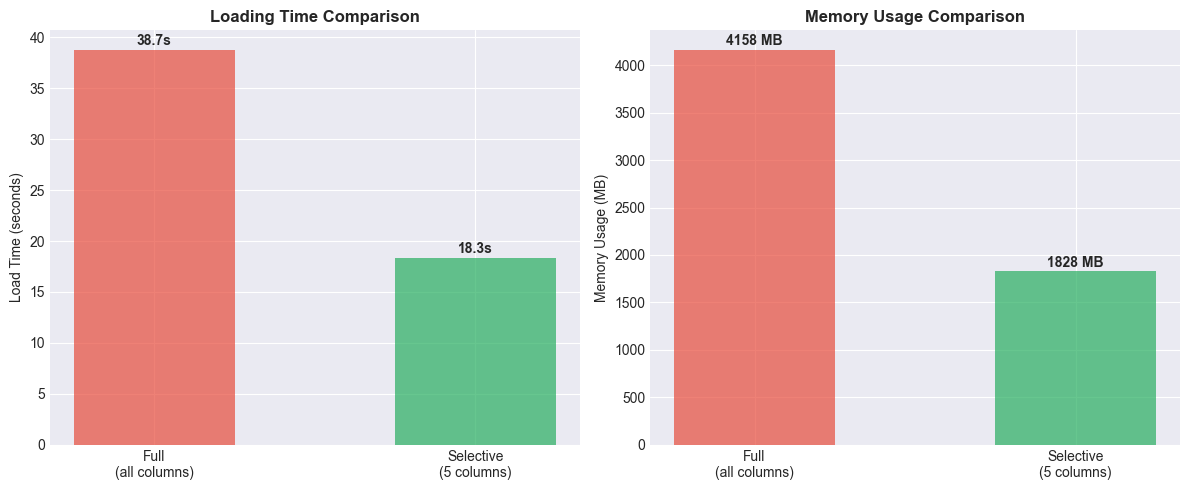


Saved: 01_selective_loading.png


In [6]:
# SELECTIVE COLUMN STRATEGY

print("="*70)
print("PART 5: SELECTIVE COLUMN LOADING")
print("="*70 + "\n")

# Define columns we actually need for analysis
needed_cols = [
    'transaction_id',
    'final_amount',
    'payment_method',
    'transaction_date',
    'status'
]

print(f"Loading only {len(needed_cols)} columns instead of all...")

# Compare full vs selective loading
print("\nComparison: Full vs Selective Loading\n")

# Full dataset
mem_start = get_memory_usage()
start = time.time()
df_full = pd.read_csv(TRANSACTIONS_FILE)
time_full = time.time() - start
mem_full = get_memory_usage() - mem_start

print(f"Full dataset:")
print(f"  Columns: {len(df_full.columns)}")
print(f"  Load time: {time_full:.2f}s")
print(f"  Memory: {mem_full:.2f} MB")

# Clean up
del df_full
gc.collect()
time.sleep(10)


# Selective loading
mem_start = get_memory_usage()
start = time.time()
df_selective = pd.read_csv(TRANSACTIONS_FILE, usecols=needed_cols)
time_selective = time.time() - start
mem_selective = get_memory_usage() - mem_start

print(f"\nSelective loading:")
print(f"  Columns: {len(df_selective.columns)}")
print(f"  Load time: {time_selective:.2f}s")
print(f"  Memory: {mem_selective:.2f} MB")

# Savings
time_saved = time_full - time_selective
mem_saved = mem_full - mem_selective

print(f"\nSavings:")
print(f"  Time: {time_saved:.2f}s ({(time_saved/time_full)*100:.1f}% faster)")
print(f"  Memory: {mem_saved:.2f} MB ({(mem_saved/mem_full)*100:.1f}% less)")

# Clean up
del df_selective
gc.collect()
time.sleep(10)

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Time comparison
categories = ['Full\n(all columns)', 'Selective\n(5 columns)']
times = [time_full, time_selective]
colors = ['#e74c3c', '#27ae60']

ax1.bar(categories, times, color=colors, alpha=0.7, width=0.5)
ax1.set_ylabel('Load Time (seconds)')
ax1.set_title('Loading Time Comparison', fontweight='bold')

for i, v in enumerate(times):
    ax1.text(i, v + 0.5, f'{v:.1f}s', ha='center', fontweight='bold')

# Memory comparison
memories = [mem_full, mem_selective]

ax2.bar(categories, memories, color=colors, alpha=0.7, width=0.5)
ax2.set_ylabel('Memory Usage (MB)')
ax2.set_title('Memory Usage Comparison', fontweight='bold')

for i, v in enumerate(memories):
    ax2.text(i, v + 50, f'{v:.0f} MB', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(GRAPH_DIR / '01_selective_loading.png', dpi=300)
plt.show()

print("\nSaved: 01_selective_loading.png")

## Part 6: Combined Optimizations - Best Practices

**Objective**: Apply ALL optimizations together

Combined strategy:
1. Selective column loading (`usecols`)
2. Dtype specification upfront
3. Date parsing
4. Memory-efficient data types

PART 6: COMBINED OPTIMIZATIONS

Defined optimized loading function

Comparison: Naive vs Optimized Loading

[1/2] Naive loading...
[2/2] Optimized loading...

Done!
STRATEGY COMPARISON
======================================================================\n
           Load Time (s)  Memory (MB)  Columns
Naive              31.03      4880.04    14.00
Optimized          27.95      2840.27    11.00

Improvements:
  Time: 9.9% faster
  Memory: 41.8% less

Saved: 01_optimization_comparison.csv


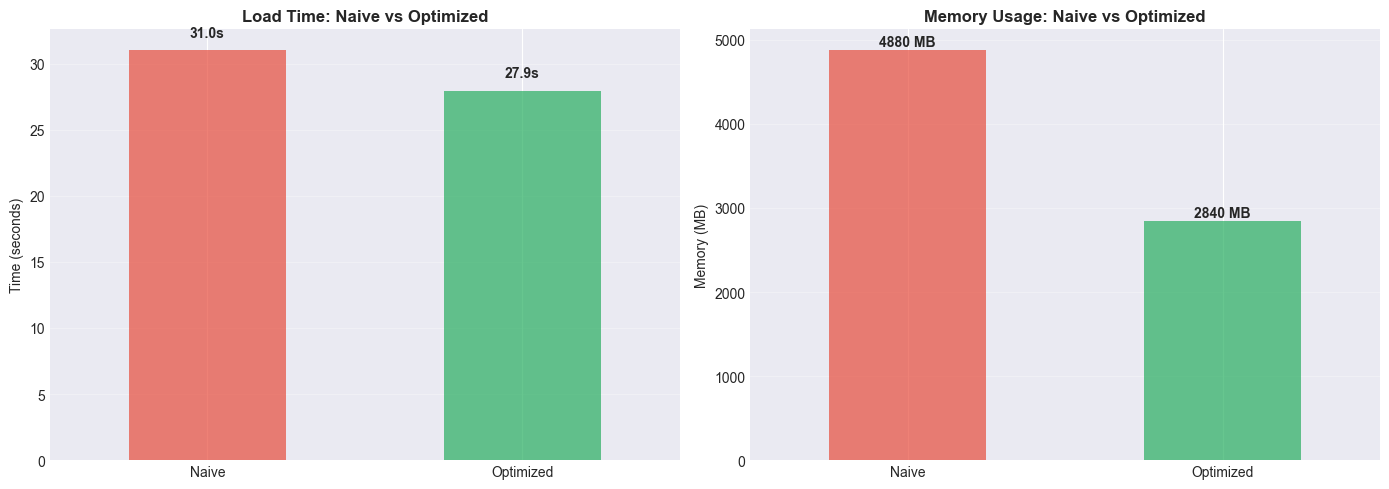


Saved: 01_combined_optimization.png


In [7]:
# COMBINED OPTIMIZATIONS

print("="*70)
print("PART 6: COMBINED OPTIMIZATIONS")
print("="*70 + "\n")

def load_transactions_optimized(filepath):
    """
    Load transactions with all optimizations applied
    
    Optimizations:
    - Selective columns
    - Dtype specification
    - Date parsing
    """
    # Define dtypes upfront
    dtypes = {
        'transaction_id': str,  # Keep as string to save memory
        'customer_id': 'category',
        'product_id': 'category',
        'quantity': 'int32',
        'unit_price': 'float32',
        'total_amount': 'float32',
        'discount_pct': 'float32',
        'final_amount': 'float32',
        'payment_method': 'category',
        'status': 'category'
    }
    
    # Select columns
    cols = list(dtypes.keys()) + ['transaction_date']
    
    # Load with optimizations
    df = pd.read_csv(
        filepath,
        dtype=dtypes,
        usecols=cols,
        parse_dates=['transaction_date']
    )
    
    return df

print("Defined optimized loading function")

# Compare strategies
print("\nComparison: Naive vs Optimized Loading\n")

strategies = {}

# Strategy 1: Naive
print("[1/2] Naive loading...")
mem_start = get_memory_usage()
start = time.time()
df_naive = pd.read_csv(TRANSACTIONS_FILE)
strategies['Naive'] = {
    'time': time.time() - start,
    'memory': get_memory_usage() - mem_start,
    'columns': len(df_naive.columns)
}

del df_naive
gc.collect()
time.sleep(10)

# Strategy 2: Optimized
print("[2/2] Optimized loading...")
mem_start = get_memory_usage()
start = time.time()
df_opt = load_transactions_optimized(TRANSACTIONS_FILE)
strategies['Optimized'] = {
    'time': time.time() - start,
    'memory': get_memory_usage() - mem_start,
    'columns': len(df_opt.columns)
}

del df_opt
gc.collect()
time.sleep(10)

print("\nDone!")

# Summary comparison
comparison_df = pd.DataFrame(strategies).T
comparison_df.columns = ['Load Time (s)', 'Memory (MB)', 'Columns']

# Calculate improvements
improvement_time = ((strategies['Naive']['time'] - strategies['Optimized']['time']) / 
                   strategies['Naive']['time']) * 100
improvement_mem = ((strategies['Naive']['memory'] - strategies['Optimized']['memory']) / 
                  strategies['Naive']['memory']) * 100

print("="*70)
print("STRATEGY COMPARISON")
print("="*70 + "\\n")
print(comparison_df.round(2))

print(f"\nImprovements:")
print(f"  Time: {improvement_time:.1f}% faster")
print(f"  Memory: {improvement_mem:.1f}% less")

# Save
comparison_df.to_csv(RESULTS_DIR / '01_optimization_comparison.csv')
print("\nSaved: 01_optimization_comparison.csv")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Time comparison
ax1 = axes[0]
comparison_df['Load Time (s)'].plot(kind='bar', ax=ax1, color=['#e74c3c', '#27ae60'], alpha=0.7)
ax1.set_ylabel('Time (seconds)')
ax1.set_title('Load Time: Naive vs Optimized', fontweight='bold')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax1.grid(axis='y', alpha=0.3)

for i, v in enumerate(comparison_df['Load Time (s)']):
    ax1.text(i, v + 1, f'{v:.1f}s', ha='center', fontweight='bold')

# Memory comparison
ax2 = axes[1]
comparison_df['Memory (MB)'].plot(kind='bar', ax=ax2, color=['#e74c3c', '#27ae60'], alpha=0.7)
ax2.set_ylabel('Memory (MB)')
ax2.set_title('Memory Usage: Naive vs Optimized', fontweight='bold')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.grid(axis='y', alpha=0.3)

for i, v in enumerate(comparison_df['Memory (MB)']):
    ax2.text(i, v + 50, f'{v:.0f} MB', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(GRAPH_DIR / '01_combined_optimization.png', dpi=300)
plt.show()

print("\nSaved: 01_combined_optimization.png")

## Part 7: Scalability Analysis

**Objective**: Test Pandas performance with increasing dataset sizes

We'll test with subsets: 1M, 5M, 10M, 15M, 20M records

PART 7: SCALABILITY ANALYSIS

Testing Pandas scalability with 5 dataset sizes...
This will take several minutes...

Testing with 1,000,000 records...
  Load time: 1.44s
  Memory: -5.34 MB
  GroupBy time: 0.05s

Testing with 5,000,000 records...
  Load time: 7.38s
  Memory: 983.07 MB
  GroupBy time: 0.21s

Testing with 10,000,000 records...
  Load time: 14.64s
  Memory: 2239.38 MB
  GroupBy time: 0.43s

Testing with 15,000,000 records...
  Load time: 22.67s
  Memory: 3505.41 MB
  GroupBy time: 0.79s

Testing with 20,000,000 records...
  Load time: 31.57s
  Memory: 3999.30 MB
  GroupBy time: 1.08s

Scalability testing complete!

SCALABILITY RESULTS

   size_millions  load_time  memory_mb  groupby_time
0           1.00       1.44      -5.34          0.05
1           5.00       7.38     983.07          0.21
2          10.00      14.64    2239.38          0.43
3          15.00      22.67    3505.41          0.79
4          20.00      31.57    3999.30          1.08

Saved: 01_scalability_ana

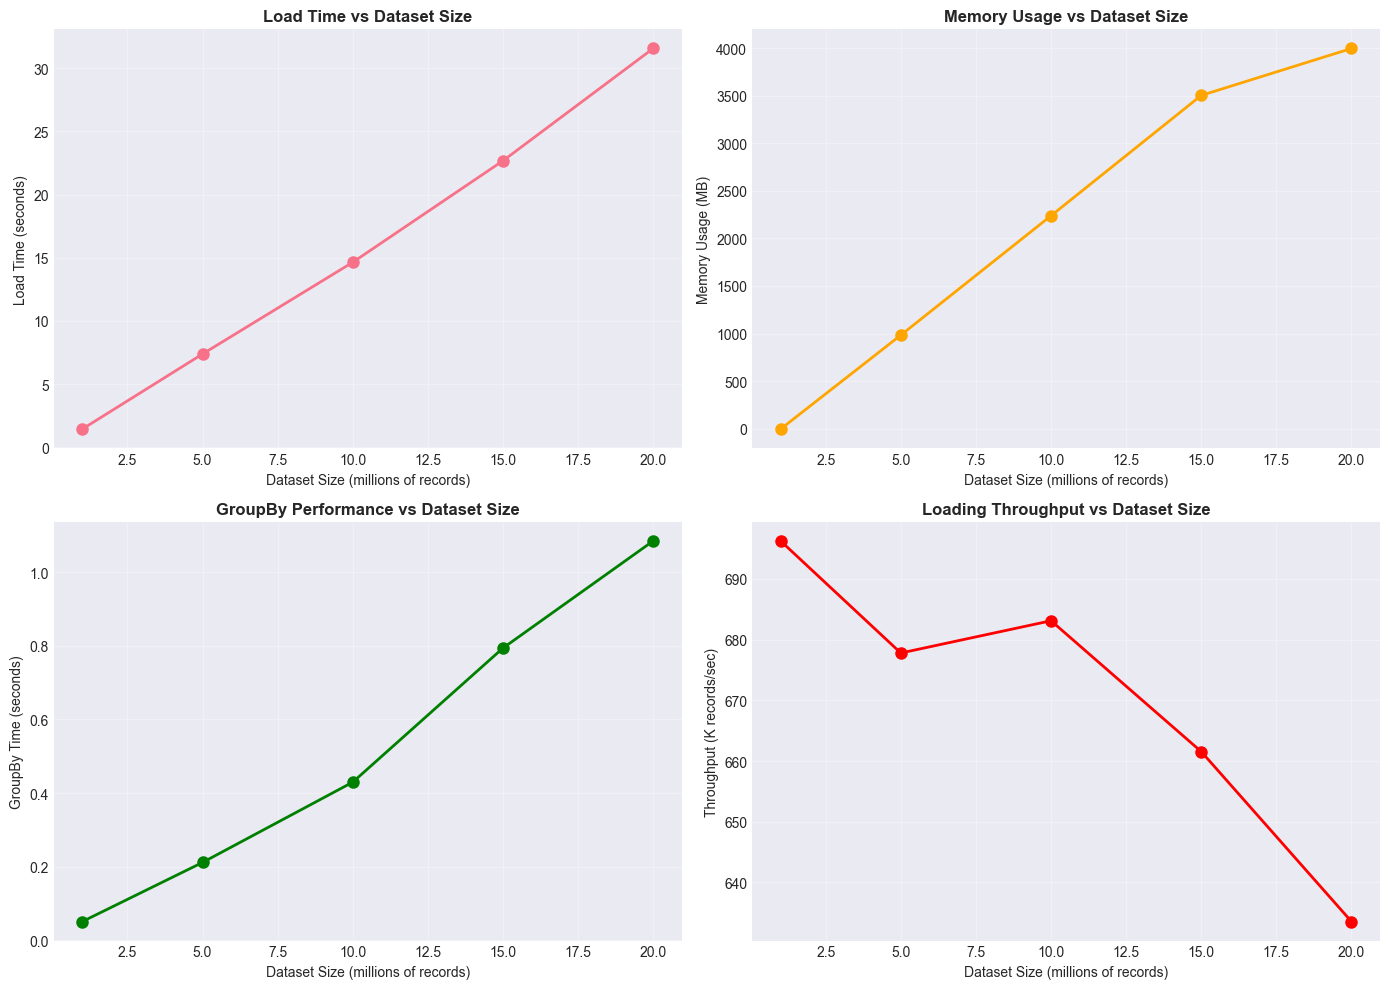


Saved: 01_scalability_analysis.png


In [8]:
# SCALABILITY ANALYSIS

print("="*70)
print("PART 7: SCALABILITY ANALYSIS")
print("="*70 + "\n")

# Test sizes
test_sizes = [1_000_000, 5_000_000, 10_000_000, 15_000_000, 20_000_000]

print(f"Testing Pandas scalability with {len(test_sizes)} dataset sizes...")
print("This will take several minutes...\n")

scalability_results = []

# Test each size
for size in test_sizes:
    print(f"Testing with {size:,} records...")
    
    # Load subset
    mem_start = get_memory_usage()
    start = time.time()
    
    df_test = pd.read_csv(TRANSACTIONS_FILE, nrows=size)
    
    load_time = time.time() - start
    mem_used = get_memory_usage() - mem_start
    
    # Test groupby operation
    start = time.time()
    _ = df_test.groupby('payment_method')['final_amount'].sum()
    groupby_time = time.time() - start
    
    # Store results
    scalability_results.append({
        'size': size,
        'load_time': load_time,
        'memory_mb': mem_used,
        'groupby_time': groupby_time
    })
    
    print(f"  Load time: {load_time:.2f}s")
    print(f"  Memory: {mem_used:.2f} MB")
    print(f"  GroupBy time: {groupby_time:.2f}s\n")
    
    # Clean up
    del df_test
    gc.collect()
    time.sleep(10)

scale_df = pd.DataFrame(scalability_results)
scale_df['size_millions'] = scale_df['size'] / 1_000_000

print("Scalability testing complete!")

# Display results
print("\n" + "="*70)
print("SCALABILITY RESULTS")
print("="*70 + "\n")
print(scale_df[['size_millions', 'load_time', 'memory_mb', 'groupby_time']].round(2))

# Save
scale_df.to_csv(RESULTS_DIR / '01_scalability_analysis.csv', index=False)
print("\nSaved: 01_scalability_analysis.csv")

# Visualization: Scalability
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Load time
ax1 = axes[0, 0]
ax1.plot(scale_df['size_millions'], scale_df['load_time'], marker='o', linewidth=2, markersize=8)
ax1.set_xlabel('Dataset Size (millions of records)')
ax1.set_ylabel('Load Time (seconds)')
ax1.set_title('Load Time vs Dataset Size', fontweight='bold')
ax1.grid(True, alpha=0.3)

# Memory usage
ax2 = axes[0, 1]
ax2.plot(scale_df['size_millions'], scale_df['memory_mb'], marker='o', linewidth=2, markersize=8, color='orange')
ax2.set_xlabel('Dataset Size (millions of records)')
ax2.set_ylabel('Memory Usage (MB)')
ax2.set_title('Memory Usage vs Dataset Size', fontweight='bold')
ax2.grid(True, alpha=0.3)

# GroupBy time
ax3 = axes[1, 0]
ax3.plot(scale_df['size_millions'], scale_df['groupby_time'], marker='o', linewidth=2, markersize=8, color='green')
ax3.set_xlabel('Dataset Size (millions of records)')
ax3.set_ylabel('GroupBy Time (seconds)')
ax3.set_title('GroupBy Performance vs Dataset Size', fontweight='bold')
ax3.grid(True, alpha=0.3)

# Efficiency (records per second)
ax4 = axes[1, 1]
scale_df['records_per_sec'] = scale_df['size'] / scale_df['load_time']
ax4.plot(scale_df['size_millions'], scale_df['records_per_sec']/1000, marker='o', linewidth=2, markersize=8, color='red')
ax4.set_xlabel('Dataset Size (millions of records)')
ax4.set_ylabel('Throughput (K records/sec)')
ax4.set_title('Loading Throughput vs Dataset Size', fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(GRAPH_DIR / '01_scalability_analysis.png', dpi=300)
plt.show()

print("\nSaved: 01_scalability_analysis.png")

### Scalability Observations

From the scalability analysis:

1. **Linear Time Growth**: Load time increases linearly with dataset size
2. **Memory Inefficiency**: Memory usage grows faster than data size (2-3x expansion)
3. **Performance Degradation**: Operations slow down with larger datasets
4. **Practical Limit**: Beyond 15-20M records, Pandas becomes impractical

**Conclusion**: Pandas is NOT designed for big data!

## Part 8: Conclusions

Pandas limitations demonstrates:

1. **Memory Inefficiency**
   - Raw CSV (2-3GB) → Pandas DataFrame (4-6GB)
   - 2-3x memory expansion factor
   - Optimization reduces by 30-50%, but still significant

2. **Performance degradation**
   - Linear/super-linear time complexity with data size
   - Simple operations become slow at 20M+ records
   - Single-threaded execution is a bottleneck

3. **Scalability ceiling**
   - Practical limit: 10-20M records on typical hardware (16GB RAM)
   - Beyond this:
     * Memory errors (OOM)
     * Extremely slow operations (minutes for simple tasks)
     * System instability